In [25]:
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tabulate import tabulate
import math
from scipy.stats import boxcox
import seaborn as sns

In [2]:
price_per_state = pd.read_csv('price_per_state.csv')
price_per_state.drop('Rank',axis = 1, inplace = True)

In [3]:
income_by_zip = pd.read_excel('Solar Data/MedianZIP3.xlsx')
income_by_zip.drop(['Mean', 'Pop'],axis = 1, inplace = True)

In [5]:
election_results = pd.read_csv('Solar Data/Election Results.csv', skiprows= 1, skipfooter=7, engine = 'python')
state_outcomes = election_results[['State', 'PVI']]
state_outcomes['results'] = state_outcomes.PVI.apply(lambda x : str(x)[0])
state_outcomes = state_outcomes[['State','results']]

/home/peter/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [6]:
solar_income = solar_data.merge(income_by_zip, left_on = 'region_name', right_on = 'Zip', how = 'inner')
solar_income_price = solar_income.merge(price_per_state, left_on = 'state_name', right_on = 'State', how = 'inner')

state_outcomes.index = state_outcomes['State']
state_outcomes_dummies = pd.get_dummies(state_outcomes.results)

solar_income_price_vote = solar_income_price.merge(state_outcomes_dummies, left_on = 'state_name', right_index = True, how = 'inner')

In [7]:
ages = pd.read_csv('Solar Data/Median age by ZIP.csv')
solar_income_price_vote_age = solar_income_price_vote.merge(ages, left_on = 'region_name', right_on = 'ZIP', how = 'inner')

In [96]:
ages.columns

Index(['ZIP', 'Population', 'Median age'], dtype='object')

In [8]:
homevalue = pd.read_csv('Solar Data/Zip_Zhvi_Summary_AllHomes.csv')
homevalue = homevalue[['RegionName', 'Zhvi']]

In [95]:
homevalue.columns

Index(['RegionName', 'Zhvi'], dtype='object')

In [92]:
ziplist = homevalue.merge(ages, left_on = 'RegionName', right_on = 'ZIP', how = 'inner')
ziplist = ziplist.merge(income_by_zip, left_on = 'RegionName', right_on = 'Zip', how = 'inner')
ziplist = ziplist[['Zip', 'RegionName']]
ziplist.to_csv('Zipcodes_To_Scrape.csv', index = False, header = True)

In [52]:
solar_income_price_vote_age_home = solar_income_price_vote_age.merge(homevalue, left_on = 'region_name', right_on = 'RegionName', how = 'inner')

In [53]:
data = solar_income_price_vote_age_home[['Zhvi','Population', 'Median age','yearly_sunlight_kwh_total', 'Median', 'Price (in cents)', 'D','percent_covered']]
data.dropna(inplace = True)

/home/peter/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [54]:
data.columns

Index(['Zhvi', 'Population', 'Median age', 'yearly_sunlight_kwh_total',
       'Median', 'Price (in cents)', 'D', 'percent_covered'],
      dtype='object')

In [55]:
data = data.rename(columns = {
             'Zhvi':'Median_Home_Value', 
             'Population':'Population', 
             'Median age':'Median_Age', 
             'yearly_sunlight_kwh_total':'Yearly_Solar_Kwh_Tot', 
             'Median':'Median_Income',
             'Price (in cents)':'Price_of_Power', 
             'D':'Democract', 
             'percent_covered':'Percent_Covered'})

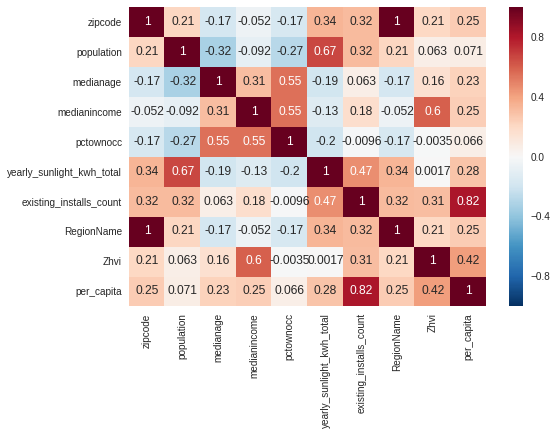

In [229]:
import seaborn as sns
corr = data.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot= True)
plt.show()

In [151]:
X = data.drop('Percent_Covered', axis = 1)
Y = data['Percent_Covered']

In [365]:
X_Train, X_test,Y_train, Y_test = train_test_split(X, Y, train_size = 0.8)
rfr = RandomForestRegressor()

rfr.fit(X_Train, Y_train)
Y_ = rfr.predict(X_test)
r2_score(Y_test, Y_)

0.44840147803187824

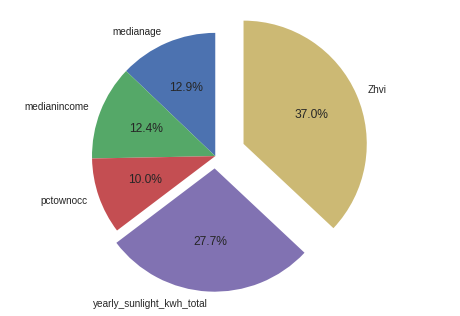

In [350]:
labels = X_Train.columns
sizes = rfr.feature_importances_
explode = (0, 0, 0 ,.1, .25)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')

plt.show()

In [351]:
score = cross_val_score(rfr, X, Y, cv=5)
print(score.mean())
print(score.std())
score

-0.167442092794
0.402987645788


array([-0.11393783,  0.30080005, -0.85890606,  0.13804913, -0.30321576])

In [352]:
gbr = GradientBoostingRegressor()
score = cross_val_score(gbr, X, Y, cv=5)
print(score.mean())
print(score.std())
score

-0.0649315520843
0.372331821717


array([-0.03199032,  0.35696998, -0.65535494,  0.28239236, -0.27667484])

In [3]:
homevalue = pd.read_csv('Solar Data/Zip_Zhvi_Summary_AllHomes.csv')
homevalue = homevalue[['RegionName', 'Zhvi']]

In [5]:
solar_data = pd.read_csv('Solar Data/project-sunroof-postal_code-09082017.csv')
solar_data.drop(0, inplace = True)
solar_data['region_name'] = solar_data['region_name'].apply(lambda x : int(x))

In [6]:
test = pd.read_csv('scraped_from_census.csv')
test= test[['zipcode', 'population','medianage', 'medianincome','pctownocc']]
test_solar = solar_data[['region_name','existing_installs_count']].merge(test, left_on = 'region_name', right_on = 'zipcode', how = 'inner')
test_solar_home = test_solar.merge(homevalue, left_on = 'zipcode', right_on = 'RegionName', how = 'inner')
solar_rad = pd.read_csv('Solar_Radiation_by_zip.csv')
solar_rad = solar_rad[solar_rad.solar_radiation !=  'error']
test_solar_home_rad = test_solar_home.merge(solar_rad,on = 'zipcode', how = 'inner')

In [7]:
test.head()

,zipcode,population,medianage,medianincome,pctownocc
0,601,17912.0,37.6,10816.0,0.56
1,602,40145.0,39.5,16079.0,0.78
2,603,50546.0,39.9,16804.0,0.62
3,606,6307.0,40.8,12512.0,0.71
4,610,28210.0,40.2,17475.0,0.76


In [8]:
test_solar_home_rad= test_solar_home_rad[['zipcode',  'population',
       'medianage', 'medianincome', 'pctownocc', 'Zhvi',
       'solar_radiation','existing_installs_count']]
test_solar_home_rad['solar_radiation'] = test_solar_home_rad['solar_radiation'] .apply(lambda x : float(x))
test_solar_home = test_solar_home_rad

First we need to establish a target feature.  We'll call that per_capita and calculate it as number of installs for every 100 people in a given geographic area (zip code)

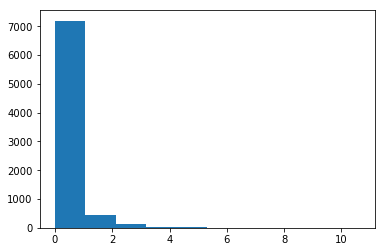

In [9]:
test_solar_home['per_capita'] = (test_solar_home['existing_installs_count']/test_solar_home['population']*100)
plt.hist(test_solar_home['per_capita'])
plt.show()

This initial data is heavily skewed towards zero.  So let's take a look at how we might be able to transform this data to make it easier for a model to get some footing.

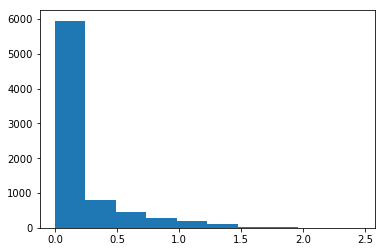

In [10]:
test = test_solar_home['per_capita'].apply(lambda x: math.log(x+1))
plt.hist(test)
plt.show()

In [11]:
test = boxcox(test_solar_home.per_capita.apply(lambda x: x+0.1))[0]

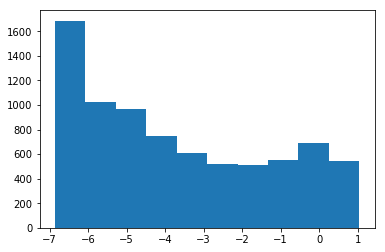

In [12]:
plt.hist(test)
plt.show()

In [13]:
test_solar_home.per_capita = test

A box cox transformation on the target normalized the distribution quite well.  Lets see what we can do to the other variables. Zhvi (median home value) should be a strong feature.  Let's take a look at the distribution and see how me might play with that data. 

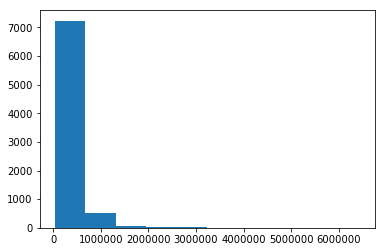

In [14]:
plt.hist(test_solar_home.Zhvi)
plt.show()

Well, there are some pretty extreme datapoints that I think we will want to eliminate so let's do that and then try some transformations

In [15]:
test_solar_home = test_solar_home[test_solar_home.Zhvi <= 1000000]

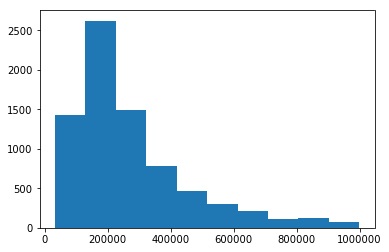

In [16]:
plt.hist(test_solar_home.Zhvi)
plt.show()

In [17]:
test_solar_home[['Zhvi', 'per_capita']].corr()

,Zhvi,per_capita
Zhvi,1.000000,0.464621
per_capita,0.464621,1.000000


Thats some pretty fair ditribution on Zhvi and we got the correlation between our target and the feature up to 0.48.  Let's see if we can do that with some other features.  Let's look at sunlight next.

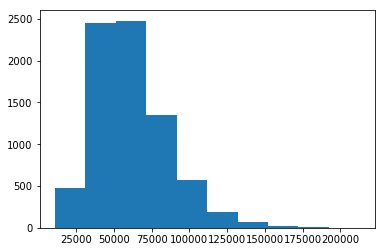

In [18]:
plt.hist(test_solar_home['medianincome'])
plt.show()

In [19]:
test_solar_home.head()

,zipcode,population,medianage,medianincome,pctownocc,Zhvi,solar_radiation,existing_installs_count,per_capita
0,1001,16830.0,44.5,60161.0,0.77,198600,3.65,0,-6.862765
1,1013,21738.0,34.9,40774.0,0.46,171500,3.69,10,-4.701932
2,1020,30874.0,43.7,55665.0,0.68,180500,3.69,15,-4.617218
3,1022,2277.0,35.6,51500.0,0.70,112300,3.69,2,-3.594419
4,1027,17719.0,44.5,58324.0,0.65,236600,3.78,7,-4.927672


In [20]:
test_solar_home = test_solar_home[test_solar_home['medianincome'] < 150000]

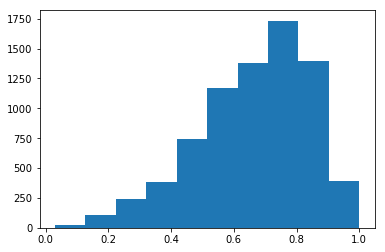

In [21]:
plt.hist(test_solar_home['pctownocc'])
plt.show()

In [22]:
test_solar_home[['pctownocc', 'per_capita']].corr()

,pctownocc,per_capita
pctownocc,1.000000,-0.044192
per_capita,-0.044192,1.000000


In [23]:
test_solar_home[['medianage', 'per_capita']].corr()

,medianage,per_capita
medianage,1.000000,0.131886
per_capita,0.131886,1.000000


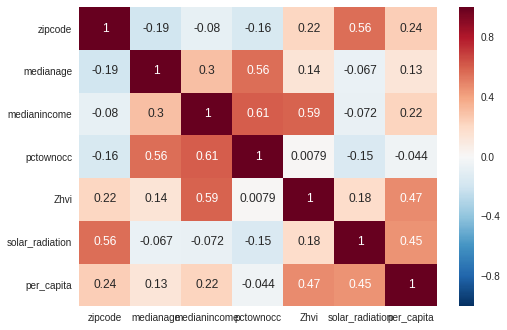

In [26]:
corr = test_solar_home.drop(['existing_installs_count','population'], axis = 1).corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot= True)
plt.show()

In [27]:
test_solar_home.dropna(inplace = True)
X = test_solar_home_rad.drop(['existing_installs_count','population','per_capita'], axis = 1)
Y = test_solar_home_rad['per_capita']

In [28]:
X_train, X_test,Y_train, Y_test = train_test_split(X, Y, train_size = 0.2)
rfr = RandomForestRegressor()

rfr.fit(X_train, Y_train)
Y_ = rfr.predict(X_test)
print('r2 : {}'.format(r2_score(Y_test, Y_)))
print('MAE: {}'.format(mean_absolute_error(Y_test, Y_)))

r2 : 0.5822421291741804
MAE: 1.2057268265689656


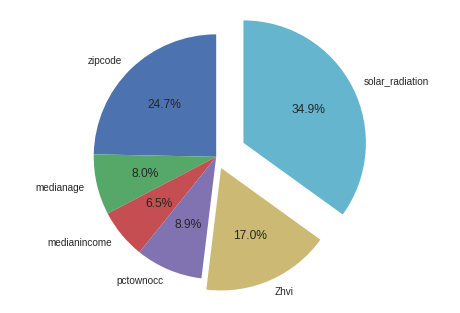

In [30]:
labels = X_train.columns
sizes = rfr.feature_importances_
explode = (0, 0,0,0  ,.1, .25)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')

plt.show()

In [31]:
score = cross_val_score(rfr, X, Y, cv=5)
print(score.mean())
print(score.std())
score

-0.0538286698463
0.119249568767


array([-0.07738602,  0.02152321, -0.13798508, -0.20685691,  0.13156146])

In [32]:
gbr = GradientBoostingRegressor()
score = cross_val_score(gbr, X, Y, cv=5)
print(score.mean())
print(score.std())
score

0.0845687767443
0.100291212472


array([ 0.00395259,  0.12906806,  0.11601406, -0.05594632,  0.22975549])

In [33]:
playing_around = test_solar_home_rad.copy()

In [35]:
test_solar_home_rad.per_capita.median()

-4.2457160465684485